In [1]:
import pandas as pd
import numpy as np
import datetime

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.layers import Dropout

import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:

topicdata = pd.read_csv(r'/Users/cairo/Google Drive/wechat data/TopicOutcomeAll20Topic.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

 
topicdata.head()

list(topicdata.columns.values) 

y = topicdata.likeCount

#X = topicdata[topicdata.columns[-30:]]
X0 = topicdata.iloc[:,-20:]
X1 = topicdata[["clicksCount", "orderNum", "originalFlag", "likeCount"]]

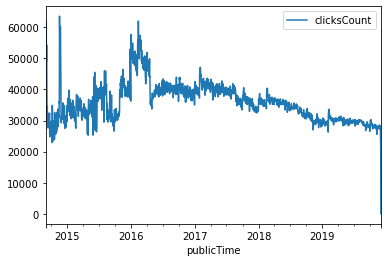

In [3]:

X0 = topicdata.iloc[:,-20:]
X1 = topicdata[["clicksCount", "orderNum", "originalFlag", "likeCount", "publicTime"]]
dd = pd.concat([X0, X1], axis=1)

#dd = topicdata[["clicksCount", "publicTime"]]

type(dd["publicTime"][0])

datetime.datetime.strptime(dd["publicTime"][0], '%Y-%m-%d %H:%M:%S')

dd["publicTime"] = pd.to_datetime(dd["publicTime"])
dd["publicTime"] = dd["publicTime"].dt.to_period('D')
dd["clicksCount"] = dd["clicksCount"].astype(float)
dd["topic1"] = dd["topic1"].astype(float)

dd.head()

#dd2 = dd.groupby(['publicTime'])['clicksCount'].mean().reset_index()

dd2 = dd.groupby(['publicTime']).agg(topic1=('topic1', 'mean'),clicksCount=('clicksCount', 'mean')).reset_index(drop=False)


dd2.set_index(['publicTime'])


#dd2['publicTime'] = dd2['publicTime'].to_timestamp()

#dd2["publicTime"].astype('datetime64[ns]') 



dd2.plot(y='clicksCount', x = "publicTime")


ppp=[]
for i in dd2["publicTime"]:
    pp = i.to_timestamp()
    ppp.append(pp)

dd2["publicTime2"] = ppp


dd3 = dd2.set_index(["publicTime2"], drop=True)
dd3.drop(dd3.tail(1).index,inplace=True)

dd3 = dd3[["clicksCount"]]


train = dd3.head(int(len(dd2)*(80/100)))

test = dd3.tail(int(len(dd2)*(20/100)))


#train = dd2['2014-09-01':'2018-12-20']
#test  = dd2['2018-12-21':]

In [4]:

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)


train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)




/Users/cairo/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


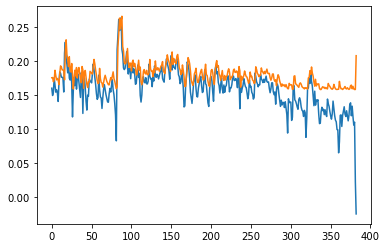

R-squared is: 0.047116
Epoch 1/20
96/96 [==============================] - 1s 786us/step - loss: 0.1735
Epoch 2/20
96/96 [==============================] - 0s 696us/step - loss: 0.0971
Epoch 3/20
96/96 [==============================] - 0s 648us/step - loss: 0.0500
Epoch 4/20
96/96 [==============================] - 0s 669us/step - loss: 0.0300
Epoch 5/20
96/96 [==============================] - 0s 813us/step - loss: 0.0201
Epoch 6/20
96/96 [==============================] - 0s 666us/step - loss: 0.0176
Epoch 7/20
96/96 [==============================] - 0s 764us/step - loss: 0.0143
Epoch 8/20
96/96 [==============================] - 0s 735us/step - loss: 0.0133
Epoch 9/20
96/96 [==============================] - 0s 628us/step - loss: 0.0137
Epoch 10/20
96/96 [==============================] - 0s 698us/step - loss: 0.0132
Epoch 11/20
96/96 [==============================] - 0s 620us/step - loss: 0.0128
Epoch 12/20
96/96 [==============================] - 0s 704us/step - loss: 0.0122
Ep

ValueError: view limit minimum -36869.75 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [71]:

from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

t = range(0,383)

plt.plot(t, y_test)
plt.plot(t, y_pred)
plt.show()




In [ ]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

In [6]:

from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)


R-squared is: 0.047116


In [72]:

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

y_pred = model.predict(X_test)


Epoch 1/20
96/96 [==============================] - 1s 892us/step - loss: 0.0130
Epoch 2/20
96/96 [==============================] - 0s 950us/step - loss: 0.0039
Epoch 3/20
96/96 [==============================] - 0s 779us/step - loss: 0.0045
Epoch 4/20
96/96 [==============================] - 0s 825us/step - loss: 0.0036
Epoch 5/20
96/96 [==============================] - 0s 705us/step - loss: 0.0041
Epoch 6/20
96/96 [==============================] - 0s 668us/step - loss: 0.0031
Epoch 7/20
96/96 [==============================] - 0s 712us/step - loss: 0.0039
Epoch 8/20
96/96 [==============================] - 0s 814us/step - loss: 0.0033
Epoch 9/20
96/96 [==============================] - 0s 719us/step - loss: 0.0038
Epoch 10/20
96/96 [==============================] - 0s 873us/step - loss: 0.0030
Epoch 11/20
96/96 [==============================] - 0s 761us/step - loss: 0.0034
Epoch 12/20
96/96 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 13/20
96/96 [========

In [76]:
aa = dd3.index.values[-int(len(dd3)*(20/100)):] 
y_pred = y_pred.reshape(383, )
aa = aa.reshape(383, )

df = pd.DataFrame({'publicTime':aa, 'y_pred':y_pred})
y_pred2 = df.set_index(["publicTime"], drop=True)

No handles with labels found to put in legend.


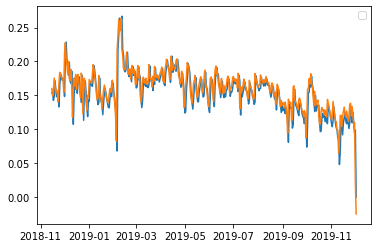

In [77]:

plt.plot(y_pred2)
plt.plot(y_test)
plt.legend()

In [82]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=5, epochs=20, verbose=1)

Epoch 1/20
307/307 [==============================] - 1s 1ms/step - loss: 0.0041
Epoch 2/20
307/307 [==============================] - 0s 670us/step - loss: 0.0030
Epoch 3/20
307/307 [==============================] - 0s 720us/step - loss: 0.0032
Epoch 4/20
307/307 [==============================] - 0s 759us/step - loss: 0.0038
Epoch 5/20
307/307 [==============================] - 0s 738us/step - loss: 0.0034
Epoch 6/20
307/307 [==============================] - 0s 709us/step - loss: 0.0030
Epoch 7/20
307/307 [==============================] - 0s 954us/step - loss: 0.0031
Epoch 8/20
307/307 [==============================] - 0s 749us/step - loss: 0.0040
Epoch 9/20
307/307 [==============================] - 0s 943us/step - loss: 0.0030
Epoch 10/20
307/307 [==============================] - 0s 931us/step - loss: 0.0030
Epoch 11/20
307/307 [==============================] - 0s 738us/step - loss: 0.0029
Epoch 12/20
307/307 [==============================] - 0s 738us/step - loss: 0.0028
Epo

In [83]:
y_pred = model.predict(X_test)

print('R-Squared: %f'%(r2_score(y_test, y_pred)))

R-Squared: 0.323124


In [84]:
aa = dd3.index.values[-int(len(dd3)*(20/100)):] 
y_pred = y_pred.reshape(383, )
aa = aa.reshape(383, )

df = pd.DataFrame({'publicTime':aa, 'y_pred':y_pred})
y_pred2 = df.set_index(["publicTime"], drop=True)

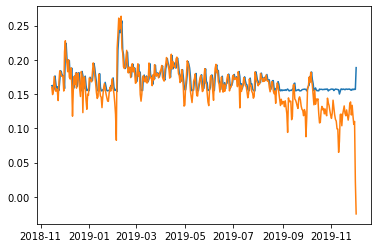

In [85]:

plt.plot(y_pred2)
plt.plot(y_test)